# Heart Disease Prediction — EDA, Data Cleaning, and Model Comparison (LogReg, RandomForest, XGBoost)


# Import

In [54]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

SEED = 42
np.random.seed(SEED)

DATA_PATH = Path("../data/heart_statlog_cleveland_hungary_final.csv")  # repo path

# Preview: first rows

In [2]:
df = pd.read_csv(DATA_PATH)
df.head(10)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0
5,39,1,3,120,339,0,0,170,0,0.0,1,0
6,45,0,2,130,237,0,0,170,0,0.0,1,0
7,54,1,2,110,208,0,0,142,0,0.0,1,0
8,37,1,4,140,207,0,0,130,1,1.5,2,1
9,48,0,2,120,284,0,0,120,0,0.0,1,0


# Information about the DataFrame

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


# Sanity checks: value ranges and potential data issues

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.00,77.0
sex,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.00,1.0
chest pain type,1190.0,3.232773,0.935480,1.0,3.0,4.0,4.00,4.0
resting bp s,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.00,200.0
cholesterol,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0
fasting blood sugar,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.00,1.0
resting ecg,1190.0,0.698319,0.870359,0.0,0.0,0.0,2.00,2.0
max heart rate,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.00,202.0
exercise angina,1190.0,0.387395,0.487360,0.0,0.0,0.0,1.00,1.0
oldpeak,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.60,6.2


In [5]:
print("Shape:", df.shape)
print("Duplicates:", df.duplicated().sum())
print("\nMissing values (top):")
display(df.isna().sum().sort_values(ascending=False).head(15))

if "target" in df.columns:
    vc = df["target"].value_counts()
    print("\nTarget distribution:")
    display(vc)
    print("Positive rate:", df["target"].mean())

Shape: (1190, 12)
Duplicates: 272

Missing values (top):


age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


Target distribution:


target
1    629
0    561
Name: count, dtype: int64

Positive rate: 0.5285714285714286


# Numeric feature distributions

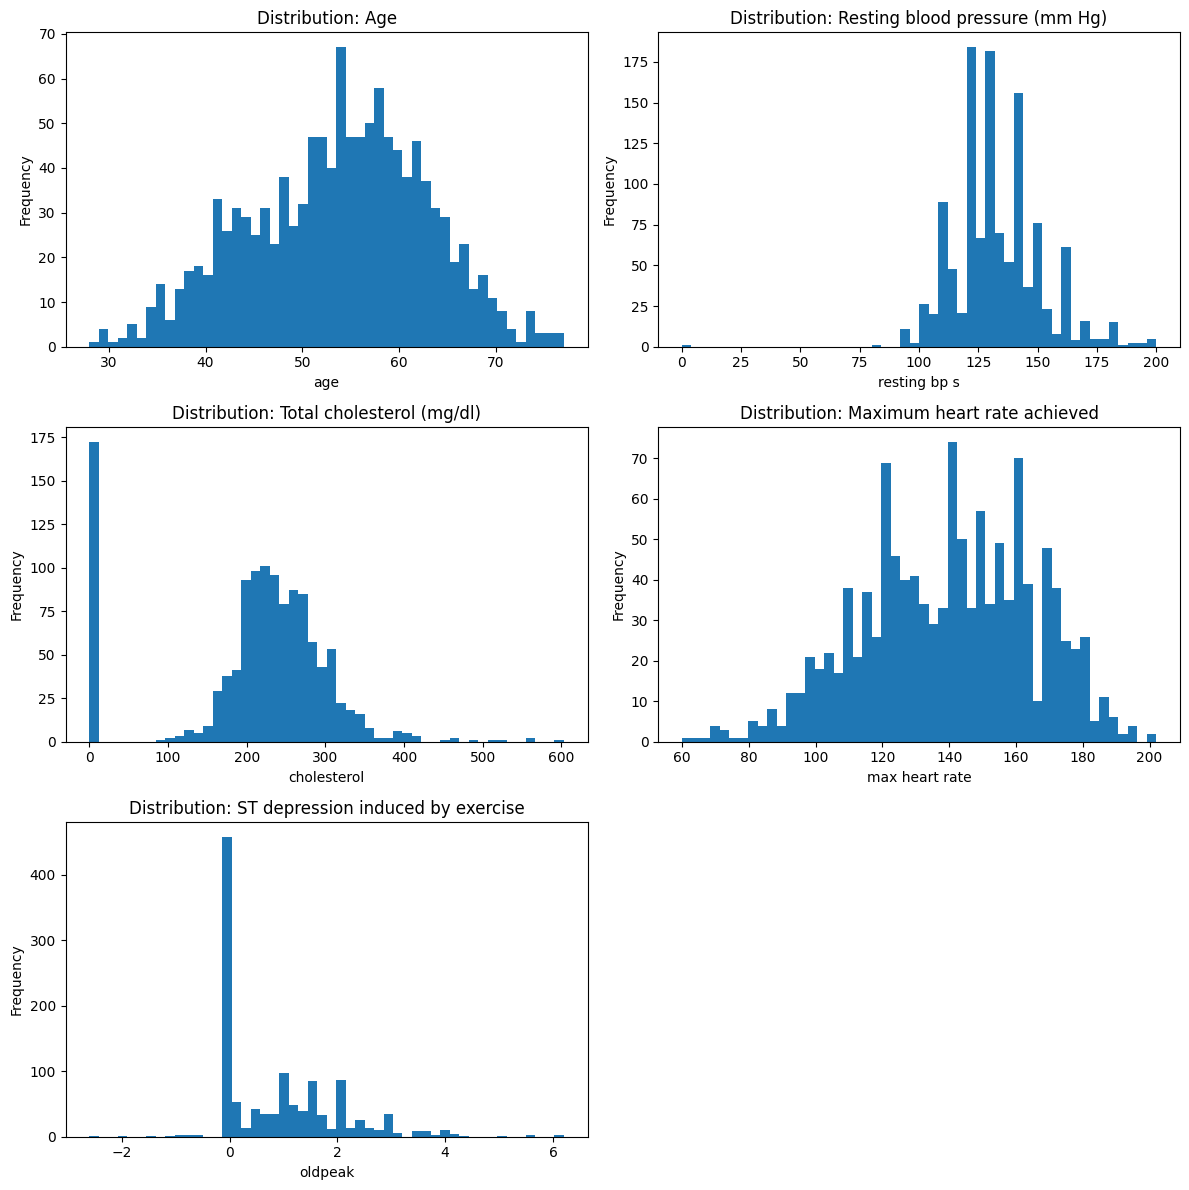

In [7]:
num_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
titles = {
    'age': 'Age',
    'resting bp s': 'Resting blood pressure (mm Hg)',
    'cholesterol': 'Total cholesterol (mg/dl)',
    'max heart rate': 'Maximum heart rate achieved',
    'oldpeak': 'ST depression induced by exercise'
}

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
axes = axes.ravel()

for i, col in enumerate(num_columns):
    ax = axes[i]
    s = df[col].dropna()

    ax.hist(s, bins=50)
    ax.set_title(f"Distribution: {titles.get(col, col)}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

axes[-1].axis("off")

plt.tight_layout()
plt.show()

### Key data quality issues observed

While exploring the feature ranges, a few values look **physiologically impossible** and should be treated as **missing / invalid**:

- `cholesterol == 0` (total cholesterol cannot be 0 for a living patient);
- `resting bp s == 0` (resting blood pressure cannot be 0);
- `oldpeak < 0` (ST depression is expected to be non‑negative in this dataset).

In the next section, we compare multiple cleaning strategies to handle these cases in a principled way.


# Nominal and binary feature distribution

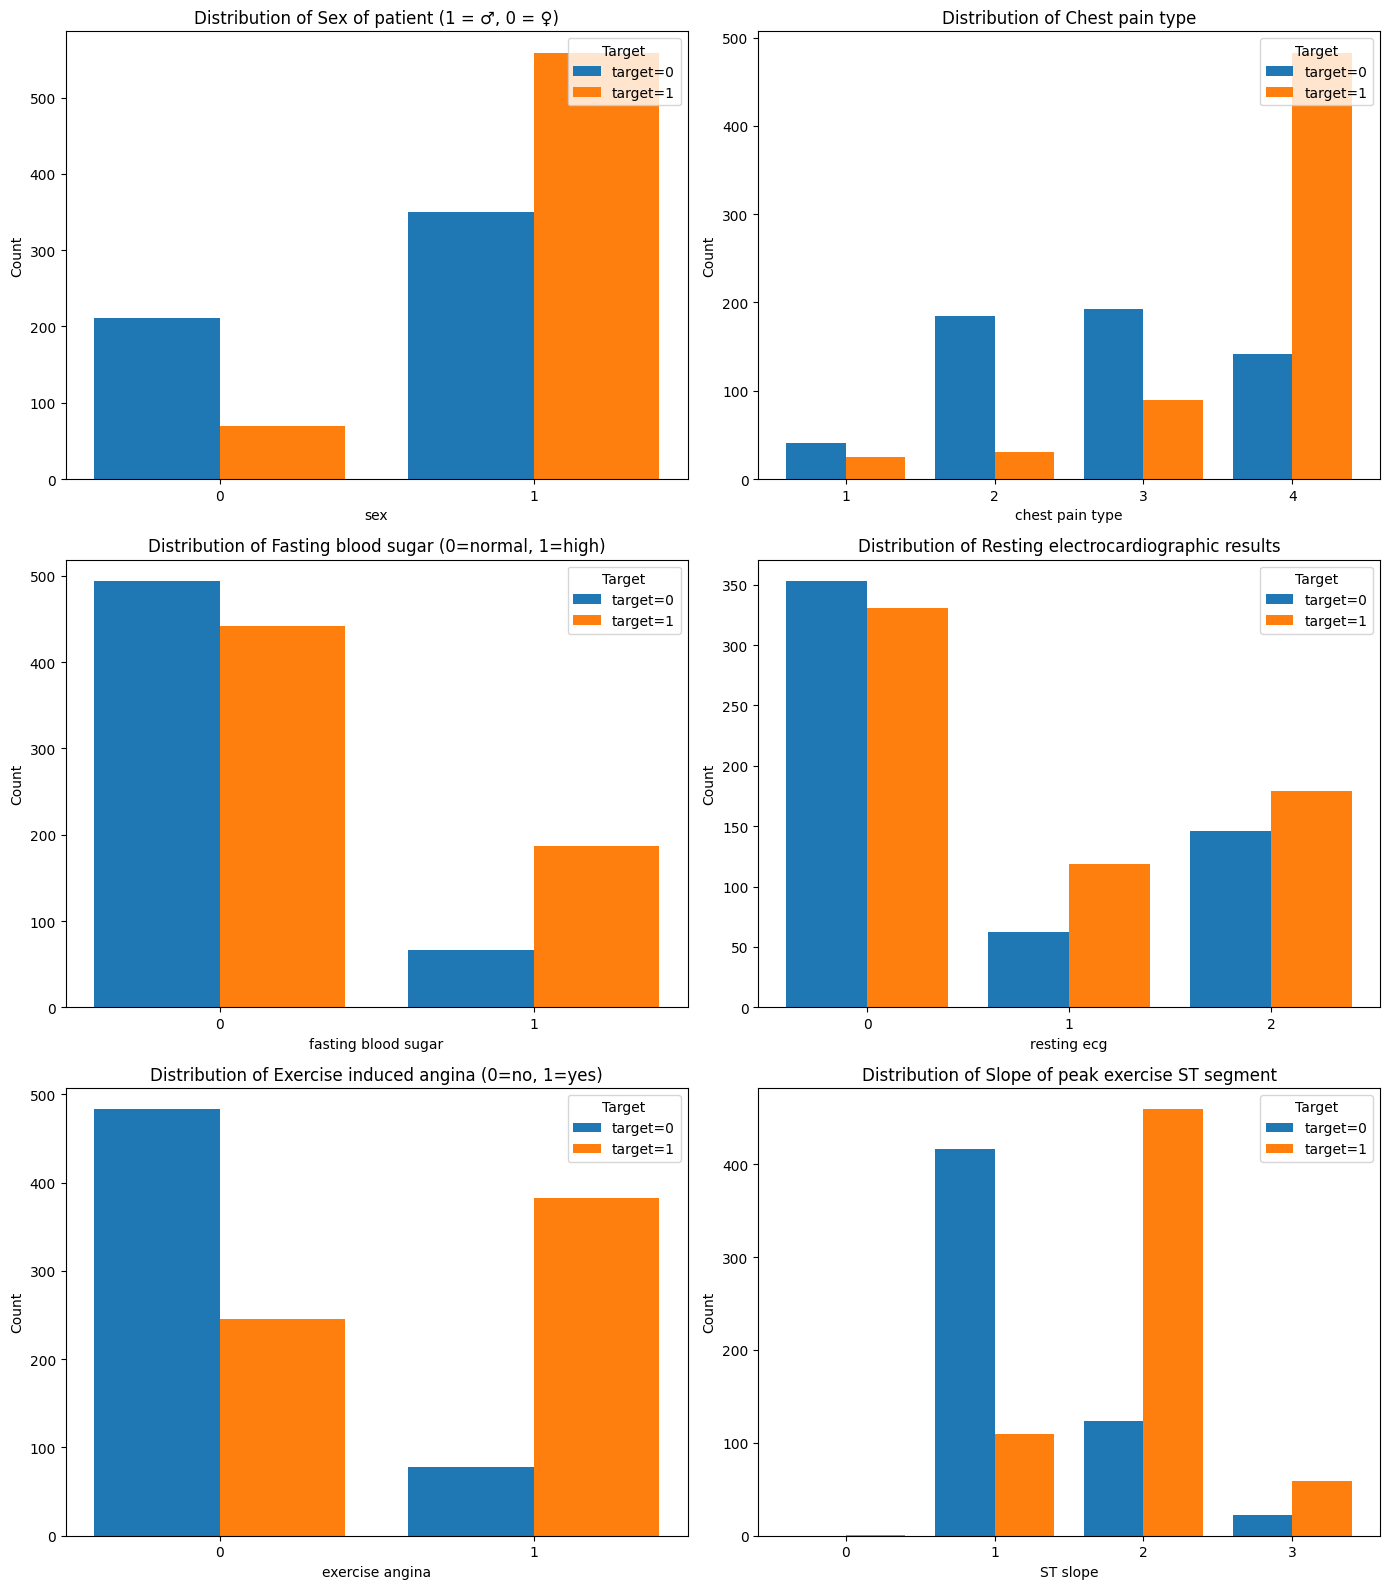

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

nominal_columns = [
    "sex",
    "chest pain type",
    "fasting blood sugar",
    "resting ecg",
    "exercise angina",
    "ST slope",
]

labels = [
    "Sex of patient (1 = ♂, 0 = ♀)",
    "Chest pain type",
    "Fasting blood sugar (0=normal, 1=high)",
    "Resting electrocardiographic results",
    "Exercise induced angina (0=no, 1=yes)",
    "Slope of peak exercise ST segment",
]

target_col = "target"

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))
axes = axes.flatten()

for i, (col, title) in enumerate(zip(nominal_columns, labels)):

    ct = pd.crosstab(df[col], df[target_col])
    
    x = np.arange(len(ct.index))
    w = 0.4

    axes[i].bar(x - w/2, ct[0].values, width=w, label="target=0")
    axes[i].bar(x + w/2, ct[1].values, width=w, label="target=1")

    axes[i].set_title(f"Distribution of {title}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels([str(v) for v in ct.index], rotation=0)
    axes[i].legend(title="Target", loc="upper right")

plt.tight_layout()
plt.show()

# Correlation

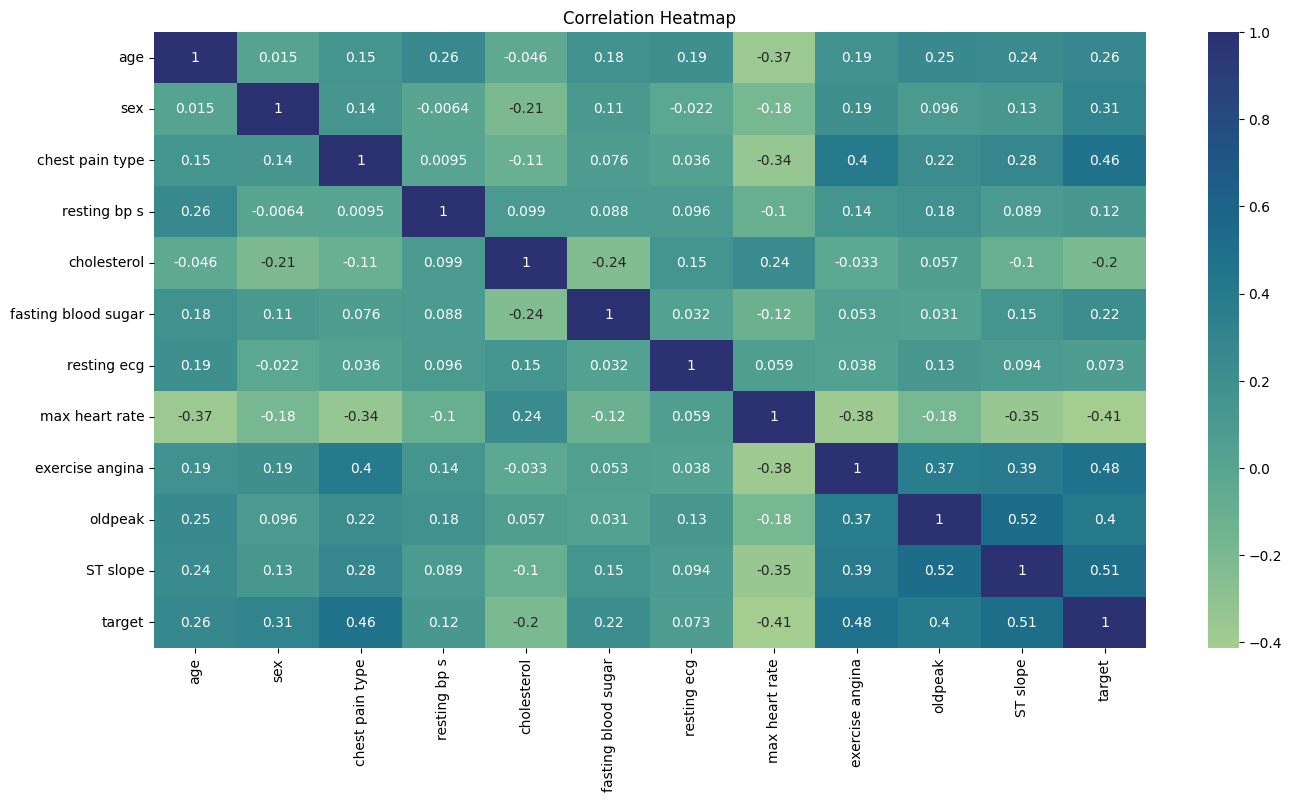

In [9]:
plt.figure(figsize=(16, 8))

corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap="crest", annot=True)

plt.title('Correlation Heatmap')
plt.show()

### **Correlation heatmap (Pearson).**

The strongest positive associations with `target` are observed for `ST slope` (0.51), `exercise angina` (0.48), `chest pain type` (0.46), and `oldpeak` (0.40), while `max heart rate` shows a moderate negative correlation (−0.41). These patterns are clinically intuitive: chest pain type and exercise-induced angina are direct symptom-related indicators, and higher `oldpeak` / changes in `ST slope` reflect abnormal ECG response to exercise, which is often linked to heart disease. In contrast, a lower achieved `max heart rate` can indicate reduced exercise tolerance, which is also common in patients with cardiovascular issues. Most other features exhibit weak correlations, suggesting that the predictive signal is distributed across multiple variables rather than driven by a single factor. Note that several predictors are categorical but encoded numerically (e.g., `chest pain type`, `resting ecg`, `ST slope`), so Pearson correlations should be interpreted as approximate indicators; non-linear models can capture additional relationships beyond linear dependence.


# Data cleaning

In [10]:
def show_impossible_stats(df, col, condition, target_col="target"):
    mask = condition(df[col])
    print(f"{col}: impossible count =", int(mask.sum()))
    if target_col in df.columns:
        display(df.loc[mask, target_col].value_counts(dropna=False))

if "cholesterol" in df.columns:
    show_impossible_stats(df, "cholesterol", lambda s: s == 0)

if "oldpeak" in df.columns:
    show_impossible_stats(df, "oldpeak", lambda s: s < 0)

if "resting bp s" in df.columns:
    show_impossible_stats(df, "resting bp s", lambda s: s <= 0)

cholesterol: impossible count = 172


target
1    152
0     20
Name: count, dtype: int64

oldpeak: impossible count = 13


target
1    9
0    4
Name: count, dtype: int64

resting bp s: impossible count = 1


target
1    1
Name: count, dtype: int64

## Choosing a cleaning strategy

We compare three approaches:

- **DROP**: remove rows with invalid values;
- **IMPUTE_MEDIAN**: treat invalid values as missing and impute numeric features with the median (inside the pipeline);
- **IMPUTE+FLAGS**: impute with the median **and** add indicator flags (e.g., `cholesterol_missing`) so the model can learn that the value was missing.


In [60]:
COL_CHOL = "cholesterol"
COL_OLDPEAK = "oldpeak"
COL_RBPS = "resting bp s"


def make_variant(df, variant: str):
    d = df.copy()

    if variant == "IMPUTE+FLAGS":
        d["cholesterol_missing"] = (d[COL_CHOL] == 0).astype(int)
        d["resting_bp_missing"] = (d[COL_RBPS] == 0).astype(int)
        d["oldpeak_invalid"] = (d[COL_OLDPEAK] < 0).astype(int)

    d.loc[d[COL_CHOL] == 0, COL_CHOL] = np.nan
    d.loc[d[COL_RBPS] == 0, COL_RBPS] = np.nan
    d.loc[d[COL_OLDPEAK] < 0, COL_OLDPEAK] = np.nan

    if variant == "DROP":
        d = d.dropna(subset=[COL_CHOL, COL_RBPS, COL_OLDPEAK]).copy()

    return d


def eval_variant(df_in, nominal_cols, numeric_cols, model, seed=42):
    X = df_in.drop(columns=[target_col])
    y = df_in[target_col].astype(int)

    pre = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler()),
            ]), numeric_cols),
            ("cat", Pipeline([
                ("imp", SimpleImputer(strategy="most_frequent")),
                ("oh", OneHotEncoder(handle_unknown="ignore")),
            ]), nominal_cols),
        ],
        remainder="drop"
    )

    pipe = Pipeline([("pre", pre), ("model", clone(model))])

    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision", "f1": "f1"}

    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    return {
        "rows": len(df_in),
        "roc_auc_mean": float(res["test_roc_auc"].mean()),
        "roc_auc_std": float(res["test_roc_auc"].std()),
        "pr_auc_mean": float(res["test_pr_auc"].mean()),
        "pr_auc_std": float(res["test_pr_auc"].std()),
        "f1_mean": float(res["test_f1"].mean()),
        "f1_std": float(res["test_f1"].std()),
    }


MODELS = {
    "LogisticRegression": LogisticRegression(max_iter=7000, class_weight="balanced"),
    "RandomForestClassifier": RandomForestClassifier(
        n_estimators=1600,
        max_depth=20,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        max_features="log2",
    ),
    "XGBClassifier": XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=1.0,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    ),
}

variants = ["DROP", "IMPUTE_MEDIAN", "IMPUTE+FLAGS"]


for model_name, model in MODELS.items():
    results = []

    for v in variants:
        d = make_variant(df, v)

        nom_cols = nominal_columns[:]
        num_cols = num_columns[:]

        if v == "IMPUTE+FLAGS":
            num_cols = num_cols + ["cholesterol_missing", "resting_bp_missing", "oldpeak_invalid"]

        out = eval_variant(d, nom_cols, num_cols, model)
        out["variant"] = v
        results.append(out)

    print(f"Result for: {model_name}")
    res_df = pd.DataFrame(results).sort_values("roc_auc_mean", ascending=False)
    display(res_df)

Result for: LogisticRegression


,rows,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std,variant
2,1190,0.920937,0.015214,0.926277,0.015990,0.863244,0.022921,IMPUTE+FLAGS
1,1190,0.916375,0.016220,0.919201,0.018910,0.854423,0.022409,IMPUTE_MEDIAN
0,1017,0.912307,0.034161,0.900945,0.047497,0.838227,0.047306,DROP


Result for: RandomForestClassifier


,rows,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std,variant
0,1017,0.973840,0.021685,0.963317,0.038361,0.934224,0.019868,DROP
2,1190,0.972216,0.008001,0.966586,0.012083,0.945742,0.012708,IMPUTE+FLAGS
1,1190,0.970006,0.009758,0.962978,0.015174,0.941833,0.015014,IMPUTE_MEDIAN


Result for: XGBClassifier


,rows,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std,f1_mean,f1_std,variant
2,1190,0.966618,0.007663,0.954379,0.016701,0.939765,0.014304,IMPUTE+FLAGS
1,1190,0.963984,0.010630,0.953276,0.019208,0.939938,0.016038,IMPUTE_MEDIAN
0,1017,0.963679,0.024985,0.944707,0.049231,0.935899,0.015955,DROP


# Selected approach: `IMPUTE+FLAGS`

Based on cross‑validated results, `IMPUTE+FLAGS` provides the best overall performance and stability, while keeping all rows. We will use it for the final models below.


In [12]:
df_model = df.copy()

df_model["cholesterol_missing"] = (df_model[COL_CHOL] == 0).astype(int)
df_model["resting_bp_missing"] = (df_model[COL_RBPS] == 0).astype(int)
df_model["oldpeak_invalid"] = (df_model[COL_OLDPEAK] < 0).astype(int)

df_model.loc[df_model[COL_CHOL] == 0, COL_CHOL] = np.nan
df_model.loc[df_model[COL_RBPS] == 0, COL_RBPS] = np.nan
df_model.loc[df_model[COL_OLDPEAK] < 0, COL_OLDPEAK] = np.nan

df_model.shape, df_model[[COL_CHOL, COL_RBPS, COL_OLDPEAK]].isna().sum()

((1190, 15),
 cholesterol     172
 resting bp s      1
 oldpeak          13
 dtype: int64)

## Train / test split

We keep a dedicated **test set** for the final evaluation. All preprocessing steps that learn statistics (imputation, scaling, one‑hot encoding) are performed **inside** the pipeline to prevent data leakage.


In [13]:
numeric_cols = num_columns + ["cholesterol_missing", "resting_bp_missing", "oldpeak_invalid"]
categorical_cols = nominal_columns

X = df_model.drop(columns=[target_col])
y = df_model[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((833, 14), (357, 14))

# Model training (baseline)

We train three classifiers using the same preprocessing pipeline:

- Logistic Regression (linear baseline);
- RandomForest (bagging of decision trees);
- XGBoost (gradient boosting of trees).

We evaluate on a held‑out test set using ROC‑AUC, PR‑AUC, F1, precision, recall, plus the confusion matrix.


In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_cols),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]), categorical_cols),
    ],
    remainder="drop"
)

In [36]:
def train_and_evaluate(model, model_name: str):
    pipe = Pipeline([
        ("pre", preprocessor),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)

    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    print(f"\n=== {model_name} (threshold=0.5) ===")
    print(f"ROC-AUC: {roc_auc_score(y_test, proba):.4f}")
    print(f"PR-AUC : {average_precision_score(y_test, proba):.4f}")
    print(f"F1     : {f1_score(y_test, pred):.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["No disease", "Disease"],
                yticklabels=["No disease", "Disease"])
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return pipe, proba, pred

# Logistic Regression


=== LogReg (threshold=0.5) ===
ROC-AUC: 0.9306
PR-AUC : 0.9304
F1     : 0.8819

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       168
           1       0.88      0.89      0.88       189

    accuracy                           0.87       357
   macro avg       0.87      0.87      0.87       357
weighted avg       0.87      0.87      0.87       357



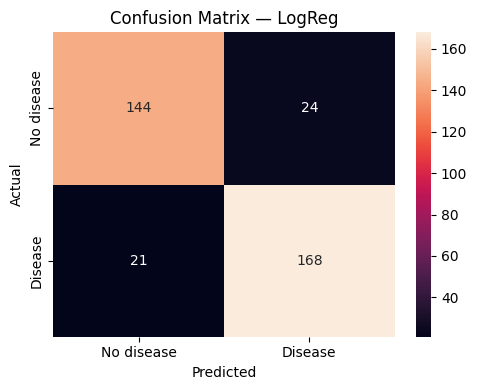

In [37]:
lr = LogisticRegression(max_iter=7000, penalty='l1' , C=0.7, solver='liblinear', class_weight="balanced")

lr_pipe, lr_proba, lr_pred = train_and_evaluate(lr, "LogReg")

# Random Forest


=== RandomForest (threshold=0.5) ===
ROC-AUC: 0.9707
PR-AUC : 0.9676
F1     : 0.9319

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       168
           1       0.92      0.94      0.93       189

    accuracy                           0.93       357
   macro avg       0.93      0.93      0.93       357
weighted avg       0.93      0.93      0.93       357



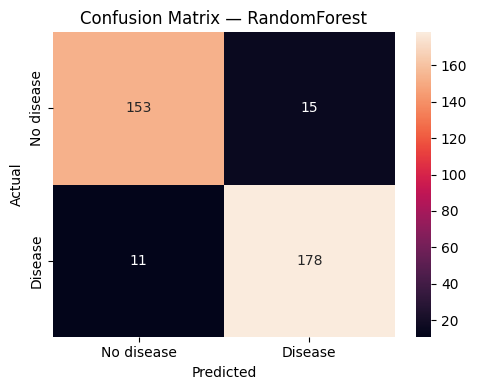

In [41]:
rf = RandomForestClassifier(
    n_estimators=1600,
    max_depth=18,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    max_features='log2'
)

rf_pipe, rf_proba, rf_pred = train_and_evaluate(rf, "RandomForest")

# XGBoost


=== XGBoost (threshold=0.5) ===
ROC-AUC: 0.9574
PR-AUC : 0.9549
F1     : 0.9396

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       168
           1       0.93      0.95      0.94       189

    accuracy                           0.94       357
   macro avg       0.94      0.93      0.94       357
weighted avg       0.94      0.94      0.94       357



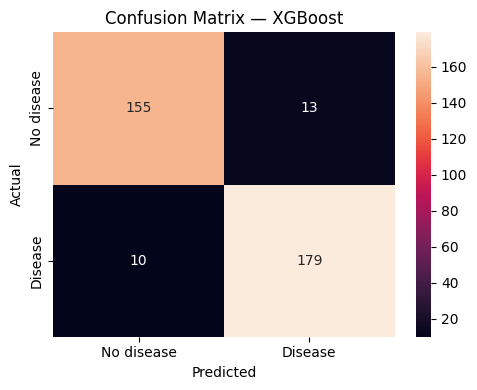

In [64]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    reg_lambda = 0.5,
    n_jobs=-1
)

xgb_pipe, xgb_proba, xgb_pred = train_and_evaluate(xgb, "XGBoost")

# Model sanity check on random test examples

This section samples a few random test rows and visualizes the predicted class probabilities, together with the true label. This helps validate that the pipeline behaves as expected.

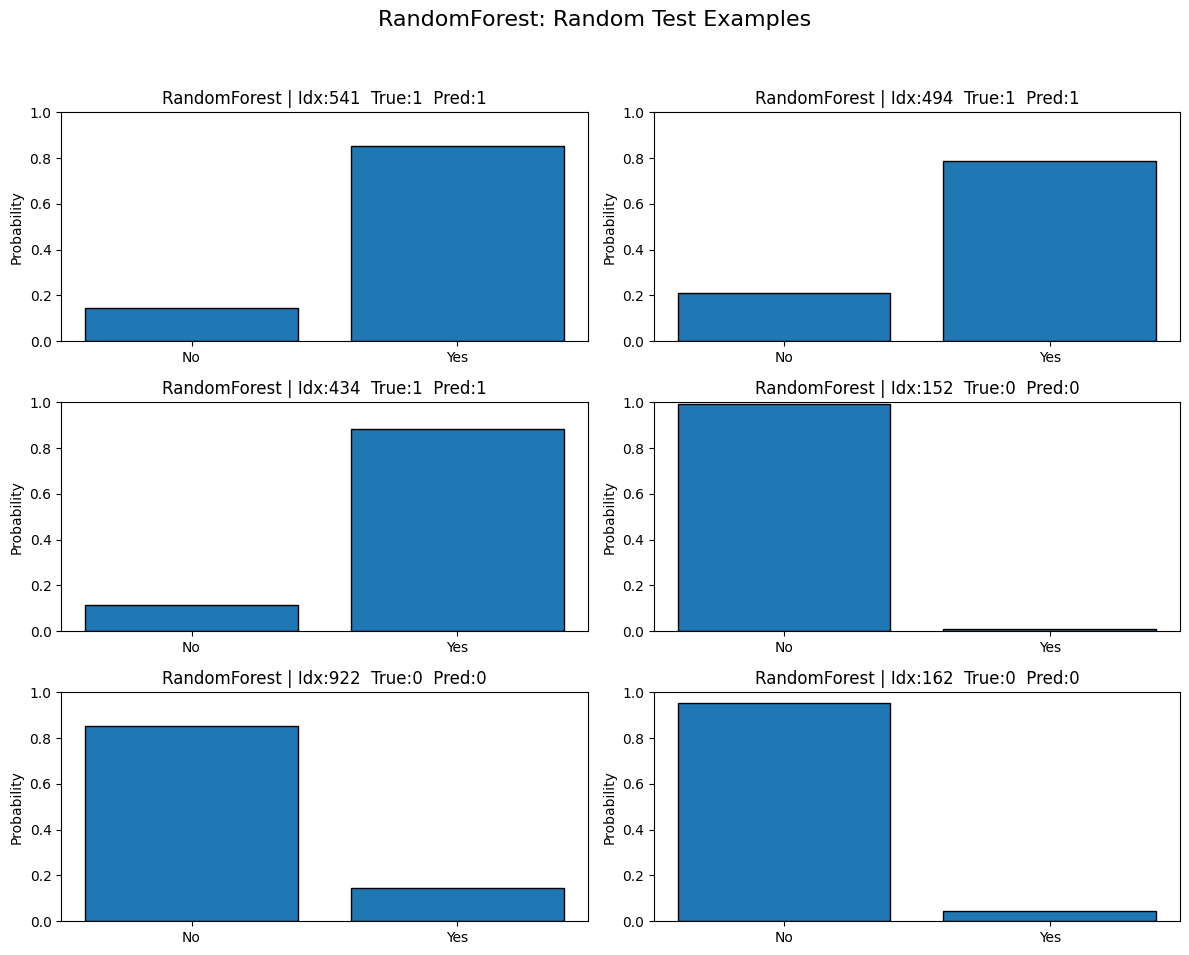


Selected examples (features) — RandomForest:


,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,cholesterol_missing,resting_bp_missing,oldpeak_invalid
541,62,1,3,138.0,204.0,0,1,122,1,1.2,2,0,0,0
494,51,1,3,137.0,339.0,0,0,127,1,1.7,2,0,0,0
434,46,1,4,110.0,236.0,0,0,125,1,2.0,2,0,0,0
152,40,1,2,130.0,275.0,0,0,150,0,0.0,1,0,0,0
922,42,1,4,140.0,226.0,0,0,178,0,0.0,1,0,0,0
162,47,1,2,160.0,263.0,0,0,174,0,0.0,1,0,0,0


In [19]:
MODEL = rf_pipe           # lr_pipe / rf_pipe / xgb_pipe
MODEL_NAME = "RandomForest" # LogReg / RandomForest / XGBoost
N_SAMPLES = 6

def check_model_on_random_examples(model, model_name, X_test, y_test,
                                   n_samples=6, seed=42, cols=2, figsize=(12, 10)):
    random.seed(seed)
    sample_idxs = random.sample(list(X_test.index), n_samples)

    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.array(axes).flatten()

    for ax, idx in zip(axes, sample_idxs):
        x_samp = X_test.loc[[idx]]
        true = int(y_test.loc[idx])

        proba = model.predict_proba(x_samp)[0] 
        pred = int(model.predict(x_samp)[0])

        ax.bar(["No", "Yes"], proba, edgecolor="k")
        ax.set_ylim(0, 1)
        ax.set_title(f"{model_name} | Idx:{idx}  True:{true}  Pred:{pred}")
        ax.set_ylabel("Probability")

    for ax in axes[n_samples:]:
        ax.axis("off")

    plt.suptitle(f"{model_name}: Random Test Examples", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"\nSelected examples (features) — {model_name}:")
    display(X_test.loc[sample_idxs])

check_model_on_random_examples(MODEL, MODEL_NAME, X_test, y_test, n_samples=N_SAMPLES, seed=SEED, cols=2, figsize=(12, 10))


# Hyperparameter tuning (grid search with cross‑validation)

To avoid data leakage, hyperparameters are tuned **only on the training split** using stratified K‑fold CV. The test split is used only once for the final evaluation.

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def grid_search_tqdm(pipe, param_grid, X_train, y_train, scoring="roc_auc", cv=cv):
    grid = list(ParameterGrid(param_grid))
    print(f"Total combinations: {len(grid)} | folds: {cv.get_n_splits()} | total fits: {len(grid)*cv.get_n_splits()}")

    results = []
    best_score = -np.inf
    best_params = None

    for params in tqdm(grid, desc="Grid search"):
        pipe.set_params(**params)

        cv_res = cross_validate(
            pipe,
            X_train, y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=1,
            return_train_score=False
        )
        mean_score = float(np.mean(cv_res["test_score"]))
        std_score = float(np.std(cv_res["test_score"]))

        results.append({
            "mean_test_score": mean_score,
            "std_test_score": std_score,
            "params": params
        })

        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    results_df = pd.DataFrame(results).sort_values("mean_test_score", ascending=False).reset_index(drop=True)
    print("\nBest CV score:", best_score)
    print("Best params:", best_params)
    display(results_df.head(8))

    pipe.set_params(**best_params)
    pipe.fit(X_train, y_train)

    return pipe, results_df, best_params, best_score

In [22]:
def evaluate_on_test(pipe, name):
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    print("\n" + "="*60)
    print("TEST:", name)
    print("="*60)
    print(f"ROC-AUC: {roc_auc_score(y_test, proba):.4f}")
    print(f"PR-AUC : {average_precision_score(y_test, proba):.4f}")
    print(f"F1     : {f1_score(y_test, pred):.4f}")
    print(f"Precision: {precision_score(y_test, pred):.4f}")
    print(f"Recall   : {recall_score(y_test, pred):.4f}")

    print("\nClassification report:")
    print(classification_report(y_test, pred))

    print("Confusion matrix:")
    print(confusion_matrix(y_test, pred))

# Logistic Regression — grid search

In [23]:
lr_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", LogisticRegression(max_iter=7000, class_weight="balanced"))
])

lr_grid = {
    "model__solver": ["liblinear"],          # l1 и l2
    "model__penalty": ["l1", "l2"],
    "model__C": [0.001, 0.01, 0.1, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 3, 10, 30]
}

best_lr, lr_res, lr_best_params, lr_best_cv = grid_search_tqdm(
    lr_pipe, lr_grid, X_train, y_train, scoring="roc_auc"
)

lr_test = evaluate_on_test(best_lr, "Best LogReg")


Total combinations: 28 | folds: 5 | total fits: 140


Grid search: 100%|█████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  7.94it/s]


Best CV score: 0.9172066330294179
Best params: {'model__C': 0.7, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


,mean_test_score,std_test_score,params
0,0.917207,0.013502,"{'model__C': 0.7, 'model__penalty': 'l1', 'mod..."
1,0.917151,0.013451,"{'model__C': 0.5, 'model__penalty': 'l1', 'mod..."
2,0.916971,0.013009,"{'model__C': 0.3, 'model__penalty': 'l1', 'mod..."
3,0.916948,0.013510,"{'model__C': 0.6, 'model__penalty': 'l1', 'mod..."
4,0.916947,0.013533,"{'model__C': 0.8, 'model__penalty': 'l1', 'mod..."
5,0.916888,0.013684,"{'model__C': 0.9, 'model__penalty': 'l1', 'mod..."
6,0.916860,0.013202,"{'model__C': 0.4, 'model__penalty': 'l1', 'mod..."
7,0.916599,0.013849,"{'model__C': 1, 'model__penalty': 'l1', 'model..."



TEST: Best LogReg
ROC-AUC: 0.9305
PR-AUC : 0.9304
F1     : 0.8819
Precision: 0.8750
Recall   : 0.8889

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       168
           1       0.88      0.89      0.88       189

    accuracy                           0.87       357
   macro avg       0.87      0.87      0.87       357
weighted avg       0.87      0.87      0.87       357

Confusion matrix:
[[144  24]
 [ 21 168]]


# RandomForest — grid search

In [66]:
rf_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", RandomForestClassifier(
        class_weight="balanced",
        random_state=SEED,
        n_jobs=-1
    ))
])

rf_grid = {
    "model__n_estimators": [800, 1400, 1800],
    "model__max_depth": [16, 20, 22],
    "model__min_samples_split": [2, 4],
    "model__min_samples_leaf": [1, 2],
    "model__max_features": ["sqrt", "log2", 0.5]
}

best_rf, rf_res, rf_best_params, rf_best_cv = grid_search_tqdm(
    rf_pipe, rf_grid, X_train, y_train, scoring="roc_auc"
)

rf_test = evaluate_on_test(best_rf, "Best RandomForest")

Total combinations: 108 | folds: 5 | total fits: 540


Grid search: 100%|███████████████████████████████████████████████████████████████████| 108/108 [20:58<00:00, 11.65s/it]


Best CV score: 0.9556805272786285
Best params: {'model__max_depth': 16, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 1400}


,mean_test_score,std_test_score,params
0,0.955681,0.016534,"{'model__max_depth': 16, 'model__max_features'..."
1,0.955607,0.016354,"{'model__max_depth': 20, 'model__max_features'..."
2,0.955607,0.016354,"{'model__max_depth': 22, 'model__max_features'..."
3,0.955232,0.016774,"{'model__max_depth': 16, 'model__max_features'..."
4,0.955160,0.016725,"{'model__max_depth': 20, 'model__max_features'..."
5,0.955131,0.016705,"{'model__max_depth': 22, 'model__max_features'..."
6,0.955004,0.017197,"{'model__max_depth': 16, 'model__max_features'..."
7,0.954988,0.017112,"{'model__max_depth': 20, 'model__max_features'..."



TEST: Best RandomForest
ROC-AUC: 0.9704
PR-AUC : 0.9677
F1     : 0.9319
Precision: 0.9223
Recall   : 0.9418

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       168
           1       0.92      0.94      0.93       189

    accuracy                           0.93       357
   macro avg       0.93      0.93      0.93       357
weighted avg       0.93      0.93      0.93       357

Confusion matrix:
[[153  15]
 [ 11 178]]


# XGBoost — grid search

In [65]:
xgb_pipe = Pipeline([
    ("pre", preprocessor),
    ("model", XGBClassifier(
        eval_metric="logloss",
        random_state=SEED,
        n_jobs=-1
    ))
])

xgb_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.03, 0.1, 0.3],
    "model__max_depth": [8, 10, 12],
    "model__subsample": [0.5, 0.8],
    "model__colsample_bytree": [0.5, 0.8, 1.0],
    "model__min_child_weight": [1, 5],
    "model__reg_lambda": [0.3, 0.5, 0.7]
}

best_xgb, xgb_res, xgb_best_params, xgb_best_cv = grid_search_tqdm(
    xgb_pipe, xgb_grid, X_train, y_train, scoring="roc_auc"
)

xgb_test = evaluate_on_test(best_xgb, "Best XGBoost")

Total combinations: 648 | folds: 5 | total fits: 3240


Grid search: 100%|███████████████████████████████████████████████████████████████████| 648/648 [05:19<00:00,  2.03it/s]


Best CV score: 0.9539678675754624
Best params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__min_child_weight': 1, 'model__n_estimators': 100, 'model__reg_lambda': 0.5, 'model__subsample': 0.8}


,mean_test_score,std_test_score,params
0,0.953968,0.014670,"{'model__colsample_bytree': 0.8, 'model__learn..."
1,0.953826,0.014649,"{'model__colsample_bytree': 0.5, 'model__learn..."
2,0.953749,0.014231,"{'model__colsample_bytree': 0.8, 'model__learn..."
3,0.953691,0.015666,"{'model__colsample_bytree': 0.8, 'model__learn..."
4,0.953664,0.014606,"{'model__colsample_bytree': 0.5, 'model__learn..."
5,0.953328,0.016576,"{'model__colsample_bytree': 0.5, 'model__learn..."
6,0.953258,0.016421,"{'model__colsample_bytree': 0.8, 'model__learn..."
7,0.953166,0.013993,"{'model__colsample_bytree': 0.5, 'model__learn..."



TEST: Best XGBoost
ROC-AUC: 0.9574
PR-AUC : 0.9549
F1     : 0.9396
Precision: 0.9323
Recall   : 0.9471

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       168
           1       0.93      0.95      0.94       189

    accuracy                           0.94       357
   macro avg       0.94      0.93      0.94       357
weighted avg       0.94      0.94      0.94       357

Confusion matrix:
[[155  13]
 [ 10 179]]


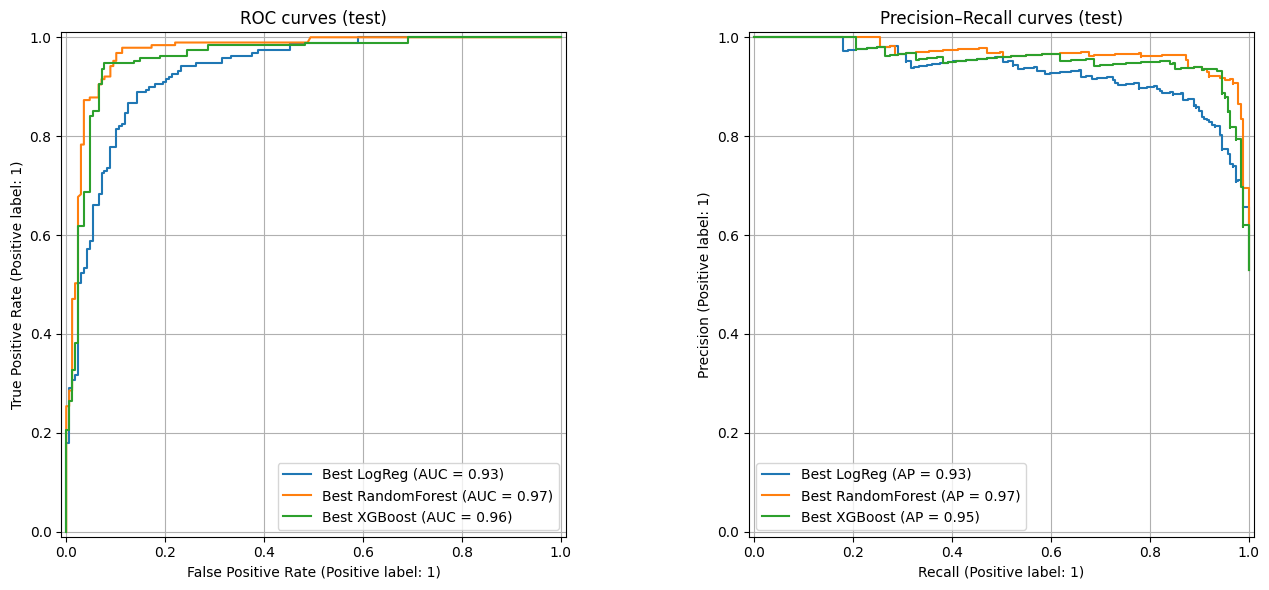

In [67]:
models = {
    "Best LogReg": best_lr,
    "Best RandomForest": best_rf,
    "Best XGBoost": best_xgb
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC
for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axes[0], name=name)
axes[0].set_title("ROC curves (test)")
axes[0].grid(True)

# PR
for name, model in models.items():
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=axes[1], name=name)
axes[1].set_title("Precision–Recall curves (test)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


I compared three models: Logistic Regression (baseline), Random Forest, and XGBoost. On the test set, Random Forest achieved better ranking quality (higher ROC-AUC/PR-AUC), meaning it separated patients by risk more consistently across thresholds. However, XGBoost performed slightly better as a classifier at the default threshold: it had a higher F1 score and made fewer mistakes in the confusion matrix. Overall, both tree-based models performed very well, but I select XGBoost as the final model because, in this scenario, making more accurate healthy vs. diseased decisions at a fixed threshold is more important.